In [1]:
import pandas as pd
from pyvis.network import Network
import numpy as np
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
%run utils.ipynb
# class 1 is illicit, 2 is licit, unknown is unknown
labels = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edges = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
nodes = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print('done')

done


In [3]:
indexes = labels.index.tolist()
labels_new = labels
labels_new = labels_new.replace('unknown', 3)
nodes_new =  nodes
edges_new = edges.loc[edges["txId1"].isin(labels_new["txId"])].loc[edges["txId2"].isin(labels_new["txId"])]
nodes_new.shape, labels_new.shape, edges_new.shape

data, graph_info = time_step_split(nodes_new, edges_new, labels_new, device)

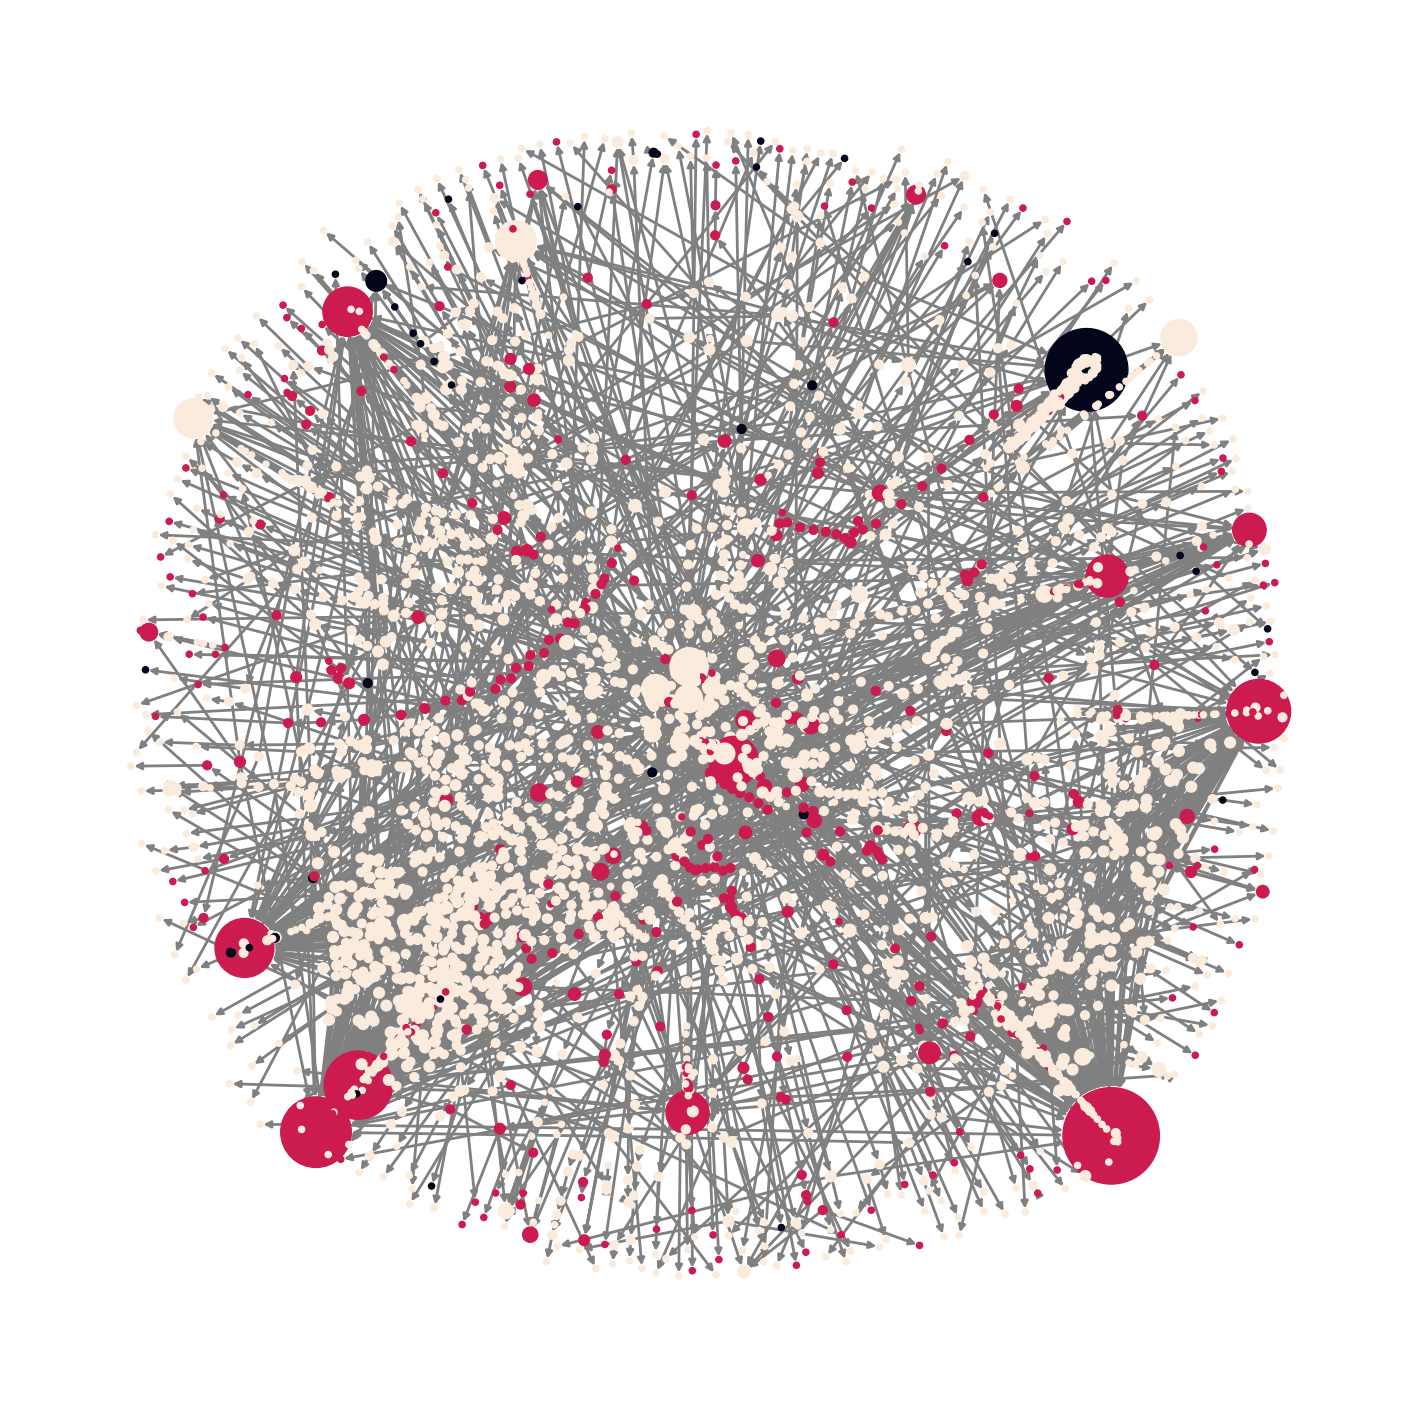

In [5]:
data_train = data['test'][0]
G = to_networkx(data_train)
degrees = [val for (node, val) in G.degree()]
degrees
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size = np.array(degrees) * 20,
                node_color=data_train.y,
                width=2,
                edge_color="grey", arrows=True
                )
plt.show()


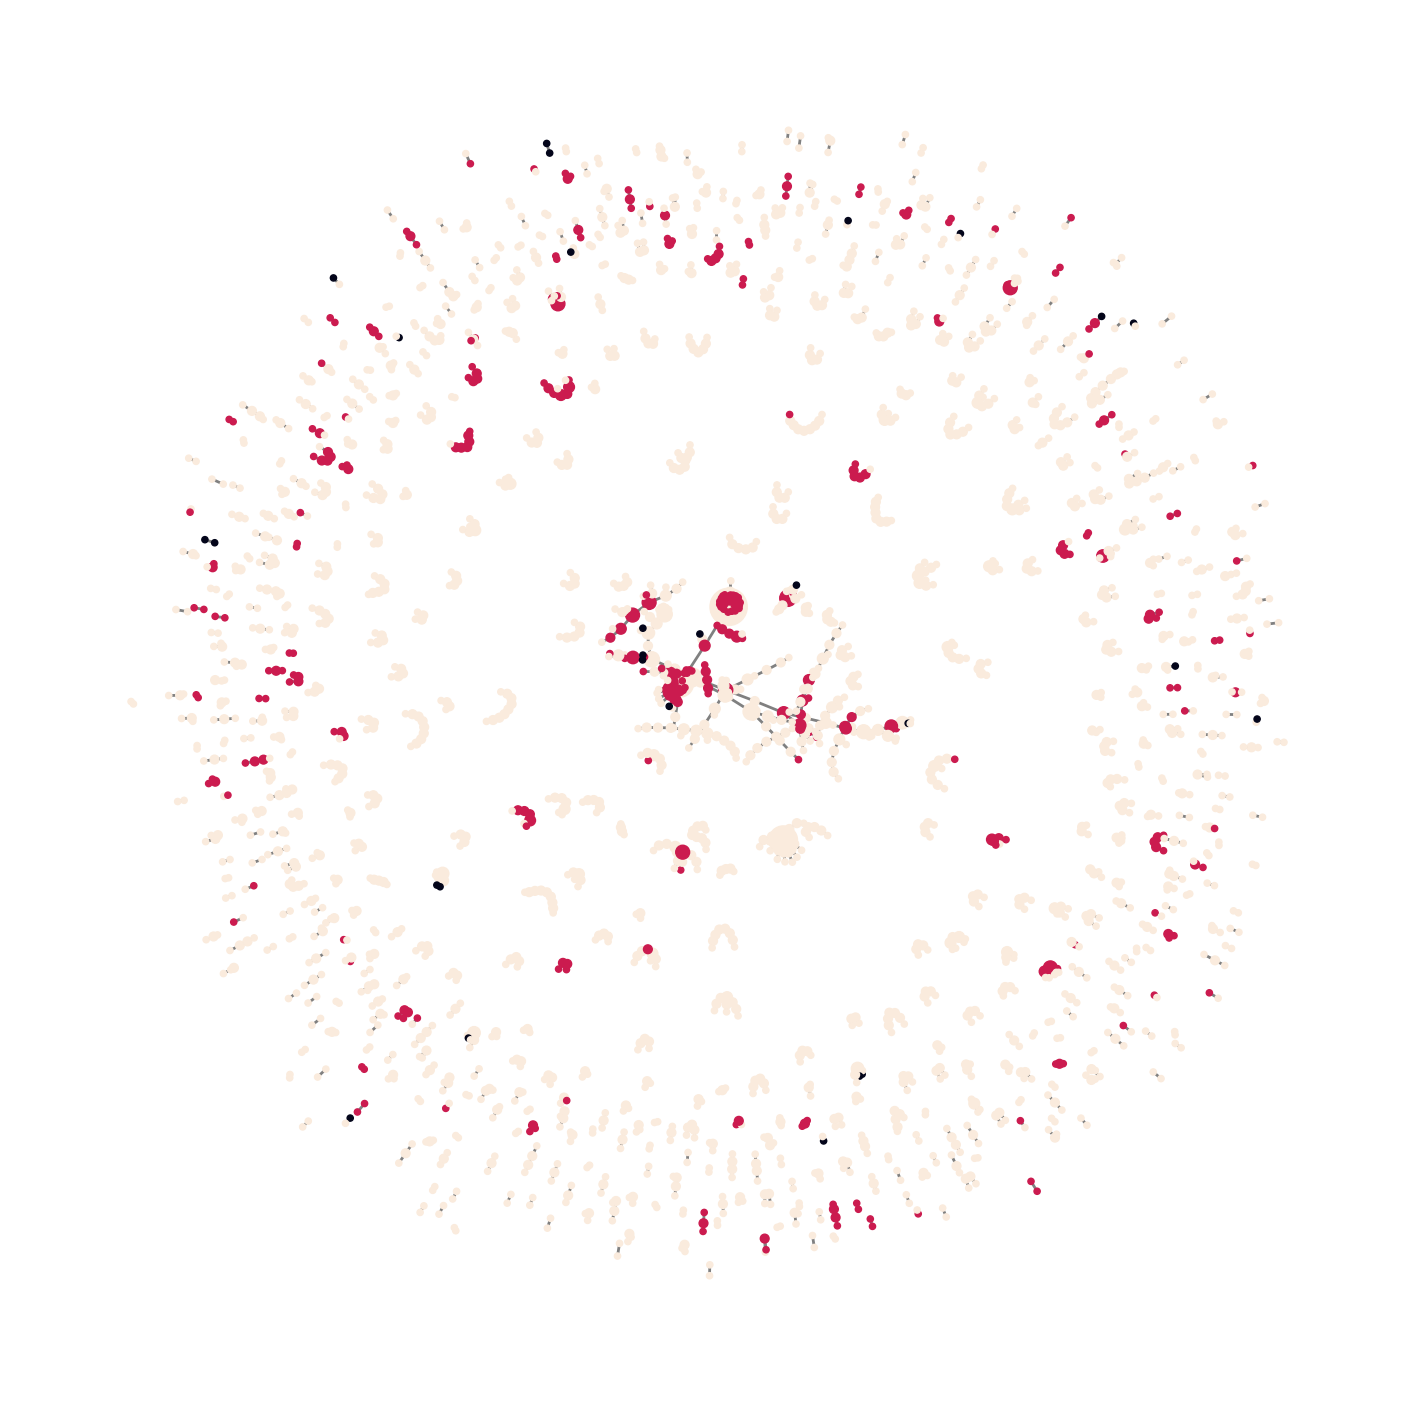

In [114]:
data_train = data['test'][0]
G = to_networkx(data_train, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 with_labels=False,
                 node_size = np.array(degrees) * 20,
                 node_color=data_train.y,
                 width=2,
                 edge_color="grey", arrows=True
                 )
plt.show()

In [18]:
from bokeh.palettes import Spectral

all_graphs = data['train'] + data['val'] + data['test']

def generateInteractiveGraph(timestep, physics=False):
    data_train = all_graphs[timestep]
    G = to_networkx(data_train)
    net = Network(
        notebook=True,
        directed =True,
        cdn_resources="remote",
        height="750px",
        width="50%",
        select_menu=True,
        filter_menu=True,
    )
    number_to_adjust_by = 5
    adjusted_node_size = dict([(node, degree * number_to_adjust_by) for node, degree in nx.degree(G)])
    nx.set_node_attributes(G,adjusted_node_size,'size')


    color_mapping = []
    color_mapping.append(Spectral[3][2])
    color_mapping.append(Spectral[3][0])
    color_mapping.append(Spectral[3][1])

    labels = dict([(node, data_train.y[node].item() + 1) for node in list(G.nodes)])
    colors = dict([(node, color_mapping[labels[node] - 1]) for node in labels])

    nx.set_node_attributes(G,colors,'color')
    nx.set_node_attributes(G,labels,'class')
    net.show_buttons(filter_=['nodes', 'edges', 'physics'])

    net.from_nx(G)
    net.toggle_physics(physics)
    for node in net.nodes:
        #Setting up node title for hovering
        node['title'] ='Id: '+ str(node['id']) + '\n Degree: ' + str(int(node['size']/5))
    net.save_graph(f"visualizations/DynamicGraphAtTimestep_{timestep}.html")
generateInteractiveGraph(13)

In [95]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Spectral

from bokeh.models import EdgesAndLinkedNodes, NodesAndLinkedEdges
#0 bad 1 good 2 unknown


In [116]:
all_graphs = data['train'] + data['val'] + data['test']
len(all_graphs)
def generateStaticGraph(timestep):
    data_train = all_graphs[timestep]
    #G = to_networkx(data_train, to_undirected=True)
    G = to_networkx(data_train)

    #degress attr
    degrees = dict(nx.degree(G))
    nx.set_node_attributes(G, name='degree', values=degrees)

    #node size
    number_to_adjust_by = 10
    max_size = 150
    adjusted_node_size = dict([(node, min((degree * number_to_adjust_by), max_size)) for node, degree in nx.degree(G)])
    nx.set_node_attributes(G, adjusted_node_size, 'adjusted_node_size')



    #labels
    labels = dict([(node, data_train.y[node].item()) for node in list(G.nodes)])
    nx.set_node_attributes(G, labels, 'class')

    #create color map
    color_mapping = []
    color_mapping.append(Spectral[3][2])
    color_mapping.append(Spectral[3][0])
    color_mapping.append(Spectral[3][1])

    #colors
    colors = dict([(node, color_mapping[labels[node]]) for node in labels])
    nx.set_node_attributes(G, colors , 'color')

    node_highlight_color = 'white'
    edge_highlight_color = 'black'


    title = f'StaticGraphAtTimestep_{timestep}'

    #Establish which categories will appear when hovering over each node
    HOVER_TOOLTIPS = [
        ("Id", "@index"),
        ("Degree", "@degree"),
        ("Class", "@class"),
    ]

    #Create a plot — set dimensions, toolbar, and title
    plot = figure(tooltips = HOVER_TOOLTIPS,
                  tools="pan,wheel_zoom,save,reset, tap", active_scroll='wheel_zoom',
                  x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,   width=1920, height=1080)

    #Create a network graph object
    # https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
    network_graph = from_networkx(G, nx.spring_layout, scale=50, center=(0, 0))

    #Set node sizes and colors according to node degree (color as category from attribute)
    network_graph.node_renderer.glyph = Circle(size='adjusted_node_size', fill_color='color')

    #Set node highlight colors
    network_graph.node_renderer.hover_glyph = Circle(size='adjusted_node_size', fill_color=node_highlight_color, line_width=2)
    network_graph.node_renderer.selection_glyph = Circle(size='adjusted_node_size', fill_color=node_highlight_color, line_width=2)

    #Set edge opacity and width
    network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
    #Set edge highlight colors
    network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=1)
    network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=1)

    #Highlight nodes and edges
    network_graph.selection_policy = NodesAndLinkedEdges()
    network_graph.inspection_policy = NodesAndLinkedEdges()
    plot.renderers.append(network_graph)

    show(plot)
    save(plot, filename=f"visualizations/{title}.html")
generateViz(12)

C:\Users\sebas\AppData\Local\Temp\ipykernel_14152\1724486863.py:75: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(plot, filename=f"visualizations/{title}.html")
C:\Users\sebas\AppData\Local\Temp\ipykernel_14152\1724486863.py:75: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  save(plot, filename=f"visualizations/{title}.html")
